# Project: Causal Inference for Software Engineering Bug Reporting 

**Objective:** To perform a structured time-series analysis with causal inference to determine if the training provided to a software engineering team was the cause for a decrease in bugs reported.

**Scenario:** A streaming service, WebFlix, delivers its content through several channels: iOS app, Android app, Roku app, Fire TV app and web browsers.  Each channel is managed by a different software engineering team.  The engineering teams track the number of bugs reported each week and monitors patterns.  Management of the Web team identified a worrying upwards trend in the number of bugs reported and provided training to the team in May 2020 to address the problem.
    
**Tools Used:** Python, Pandas, Matplotlib, Seaborn, Causal Impact

**Skills Demonstrated:** Exploratory Data Analysis, Bayesian Structural Time Series, Causal Inference, Data Visualization

**Data Source:** The CSV file contains weekly reporting of the number of bugs reported for each software engineering team in 2020.  The data is synthetic and created for the purpose of this notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from causalimpact import CausalImpact

## Exploratory Data Analysis & Time-Series Analysis

In [2]:
# Import the bug tracking data and change the date field to date type.
df = pd.read_csv('bugs.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   channel  260 non-null    object        
 1   date     260 non-null    datetime64[ns]
 2   bugs     260 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 6.2+ KB


In [4]:
df.head()

,channel,date,bugs
0,iOS,2020-01-06,15
1,iOS,2020-01-13,13
2,iOS,2020-01-20,17
3,iOS,2020-01-27,21
4,iOS,2020-02-03,12


In [5]:
# Subset for the bug reports for the Web software engineering team.
df_web = df[df['channel'] == 'Web']
df_web.head()

,channel,date,bugs
104,Web,2020-01-06,15
105,Web,2020-01-13,19
106,Web,2020-01-20,16
107,Web,2020-01-27,16
108,Web,2020-02-03,21


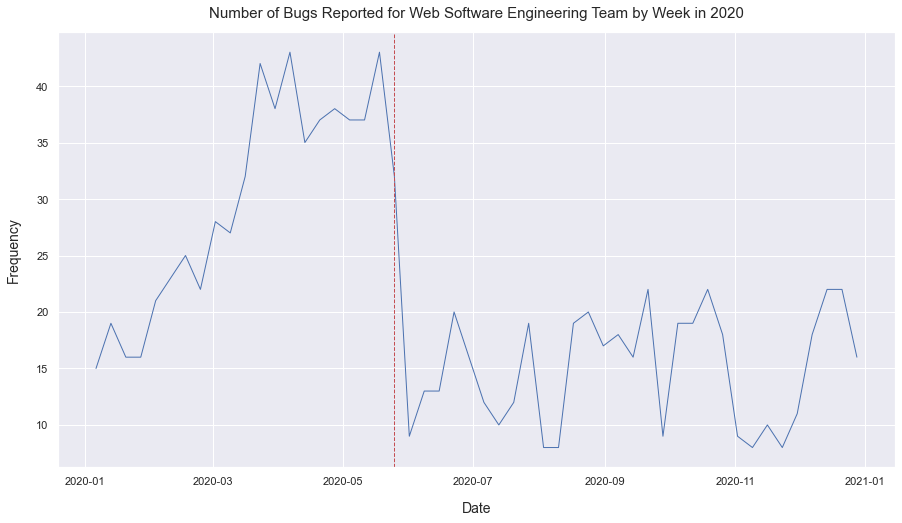

In [6]:
# Plot the bugs reported for the Web team during 2020.
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df_web, x="date", y='bugs', linewidth=1)
s.set_title('Number of Bugs Reported for Web Software Engineering Team by Week in 2020', y=1.02, fontsize=15)
s.set_xlabel('Date', fontsize=14, labelpad=15)
s.set_ylabel('Frequency', fontsize=14, labelpad=15)
plt.axvline(dt.datetime(2020,5, 25), color='r', linewidth=1, linestyle='--')
plt.show()

**Observation:** The number of bugs reported for the Web software engineering team is trending upwards in January to May 2020, well above the long running average of 12 to 15 bugs reported per month.  From June onwards, the number of bugs reported returns to normal.  This coincides with the training provided to the team in May 2020.  However, was the positive change an effect of the training or something else?

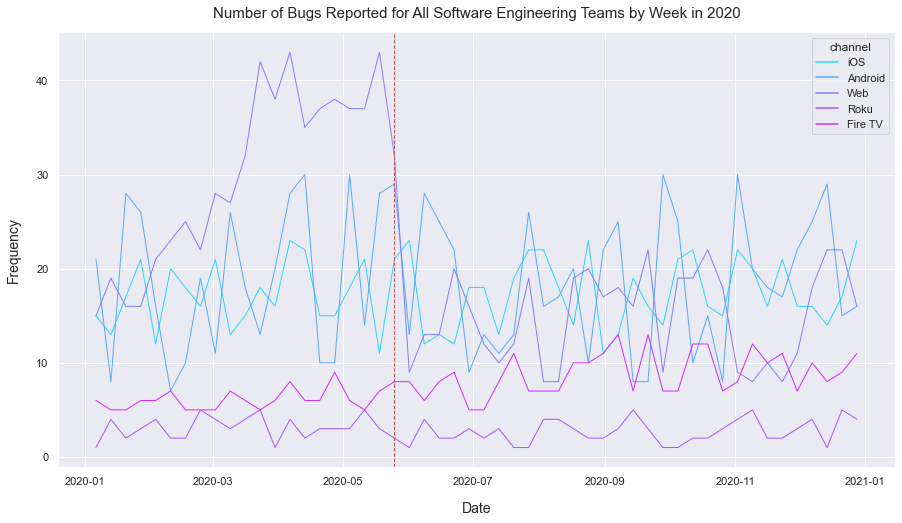

In [7]:
# Plot the bugs reported for all software engineering teams during 2020.
sns.set_theme(style='darkgrid')
plt.figure(figsize=(15,8))

s = sns.lineplot(data=df, x="date", y='bugs', hue='channel', linewidth=1, palette='cool')
s.set_title('Number of Bugs Reported for All Software Engineering Teams by Week in 2020', y=1.02, fontsize=15)
s.set_xlabel('Date', fontsize=14, labelpad=15)
s.set_ylabel('Frequency', fontsize=14, labelpad=15)
plt.axvline(dt.datetime(2020,5,25), color='r', linewidth=1, linestyle='--')
plt.show()

**Observation:** In contrast to the trends for the Web software engineering team, the respective trends for the other software engineering teams remained relatively flat throughout 2020.

## Causal Inference

Causal inference is about determining the effect of an event or intervention on a desired outcome metric. It can also be thought of as determining whether a change in the outcome metric was caused by an event or intervention.

### 1. Transform Dataset for Model

In [8]:
# Convert the dataframe into a wide form using a pivot table.
df_piv = pd.pivot_table(df, values='bugs', index='date', columns='channel', aggfunc=np.sum)

# Position the Web column as the first column. since it is our Y.  All other columns are our X.
df_piv = df_piv[['Web', 'Android', 'iOS', 'Roku', 'Fire TV']]
df_piv.head()

channel,Web,Android,iOS,Roku,Fire TV
date,,,,,
2020-01-06,15,21,15,1,6
2020-01-13,19,8,13,4,5
2020-01-20,16,28,17,2,5
2020-01-27,16,26,21,3,6
2020-02-03,21,16,12,4,6


In [9]:
# Flatten the pivot table and set the index of the dataframe to the date column. 
df_flattened = pd.DataFrame(df_piv.to_records()).reset_index(drop=True)
df_flattened = df_flattened.set_index('date')
df_flattened.head()

,Web,Android,iOS,Roku,Fire TV
date,,,,,
2020-01-06,15,21,15,1,6
2020-01-13,19,8,13,4,5
2020-01-20,16,28,17,2,5
2020-01-27,16,26,21,3,6
2020-02-03,21,16,12,4,6


### 2. Run the Causal Inference Model

In [10]:
# Set the pre_period for the model to the dates prior to the delivery of training of the Web software
# engineering team, and the post_period to the datesafter the training.
pre_period = ['20200106', '20200525']
post_period = ['20200601', '20201228']

# Run the model and display the results.
ci = CausalImpact(df_flattened, pre_period, post_period, prior_level_sd=None)

C:\Users\Nick\anaconda3\envs\sandbox_causal\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
C:\Users\Nick\anaconda3\envs\sandbox_causal\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


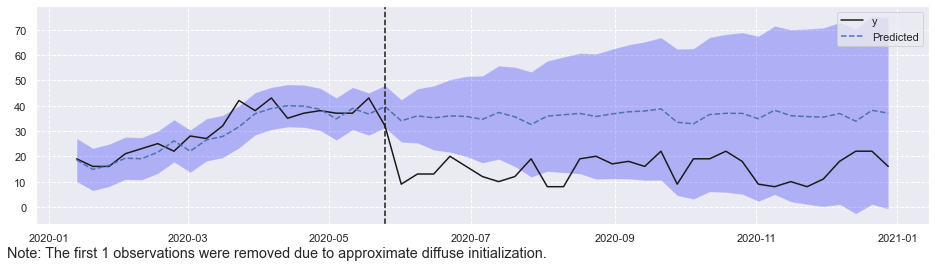

In [11]:
ci.plot(panels=['original'], figsize=(16,4))

**Observation:** This plot shows the actual bugs reported for the Web software engineering team (y) versus the prediction for the same team (Predicted), taking into consideration both the bugs reported in January to May 2020 for the Web team and the bugs reported throughout the year by the other software engineering teams.  It is evident from the plot, that the prediction for the Web team from June to December 2020 is above the actual reporting.  This indicates that an event took place in May 2020 that positively impacted the number of bugs reported by the Web team from June onwards.  This supports a conclusion that the training provided to the Web team in May 2020 was the cause for the reduction in bugs reported from June onwards.

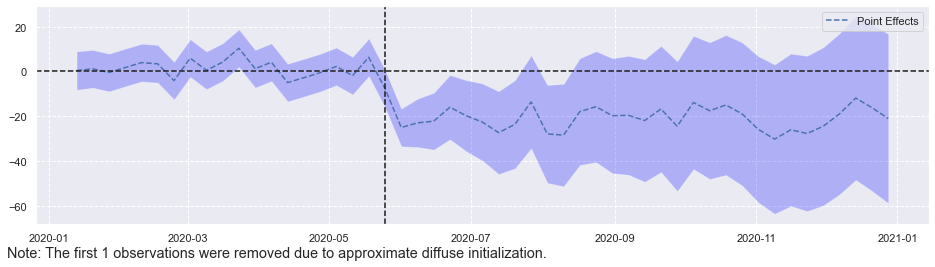

In [12]:
ci.plot(panels=['pointwise'], figsize=(16,4))

**Observation:** This plot shows the difference between the actual series and the predicted series, referred to as the point effects.

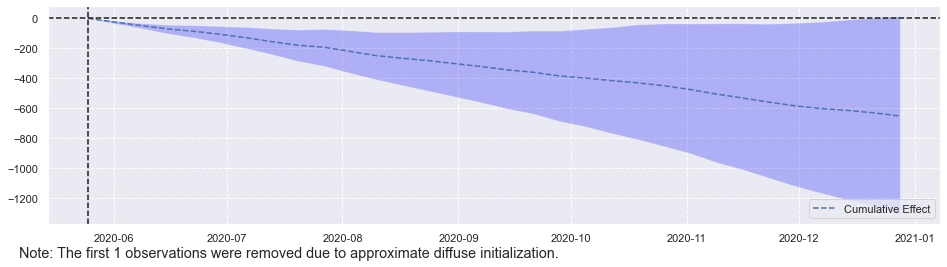

In [13]:
ci.plot(panels=['cumulative'], figsize=(16,4))

**Observation:** This plot shows the cumulative effect, which is basically the summation of the point effects accumulated over time.

In [14]:
# Display model summary output.
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    14.94              463.0
Prediction (s.d.)         35.96 (10.86)      1114.91 (336.67)
95% CI                    [14.46, 57.04]     [448.36, 1768.09]

Absolute effect (s.d.)    -21.03 (10.86)     -651.91 (336.67)
95% CI                    [-42.1, 0.47]      [-1305.09, 14.64]

Relative effect (s.d.)    -58.47% (30.2%)    -58.47% (30.2%)
95% CI                    [-117.06%, 1.31%]  [-117.06%, 1.31%]

Posterior tail-area probability p: 0.03
Posterior prob. of a causal effect: 97.3%

For more details run the command: print(impact.summary('report'))


In [15]:
# Display model analysis report.
print(ci.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 14.94. In the absence of an
intervention, we would have expected an average response of 35.96.
The 95% interval of this counterfactual prediction is [14.46, 57.04].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -21.03 with a 95% interval of
[-42.1, 0.47]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 463.0.
Had the intervention not taken place, we would have expected
a sum of 1114.91. The 95% interval of this prediction is [448.36, 1768.09].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed a decrease of -

**Conclusion:** This report confirms my earlier preliminary conclusion that the cause of the reduction in bugs reported for the Web software engineering team from June 2020 onwards was the training provided to the team in May 2020.  The probability of obtaining this effect by chance is very small and therefore the causal effect can be considered statistically significant.

The intervention, which is the training provided, had an effect of -21.03 bugs reported, with a 95% interval.  Providing the training was a good decision because it had the desired effect.